In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
from pipeline import Pipeline
from rnn import RNN
from datetime import datetime
import json
import matplotlib.pyplot as plt

### Load datasets

In [3]:
df_train = pd.read_csv("./data/train.csv")
df_valid = pd.read_csv("./data/valid.csv")

#### Process datasets

In [4]:
df_train, train_scale = Pipeline.process(data=df_train, altered=False)
df_valid, valid_scale = Pipeline.process(data=df_valid, altered=False)
df_test = df_valid[len(df_valid)//2:]
df_valid = df_valid[:len(df_valid)//2]

### Parameters
Select features and length of sequences (k)

In [5]:
k = 60
features=[
    'hydro', 
    'micro',
    'thermal',
    'wind', 
    'total',
    # 'sys_reg', 
    'flow', 
    # 'time_of_day_sin',
    # 'time_of_day_cos',
    # 'time_of_week_sin',
    # 'time_of_week_cos',
    'time_of_year_sin',
    'time_of_year_cos',
    'time_of_hour_sin',
    'time_of_hour_cos',
    # 'new_hour',
    'sum',
    'structural_imbalance',
    # 'prev_day_y',
    # 'prev_week_y',
    # 'previous_20y']
    'previous_y']
no_features = len(features)

Format data for RNN

In [6]:
x_train, y_train = Pipeline.format_data(df_train, k=k, features=features, noise_prev_no=k)
x_valid, y_valid = Pipeline.format_data(df_valid, k=k, features=features)
x_test, y_test = Pipeline.format_data(df_test, k=k, features=features)

### Build the model

In [7]:
model = RNN(k, no_features)
model.model.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 13)]          0         
                                                                 
 lstm (LSTM)                 (None, 60, 30)            5280      
                                                                 
 dropout (Dropout)           (None, 60, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                4080      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 100)               2100      
                                                                 
 dense_1 (Dense)             (None, 1)                 1

### Train the model

In [8]:
model.train(
    x_train=x_train,
    y_train=y_train,
    x_valid=x_valid, 
    y_valid=y_valid,
    epochs=10,
    batch_size=128)

Epoch 1/10
1743/1743 [==============================] - 47s 21ms/step - loss: 0.1815 - val_loss: 0.6110
Epoch 2/10
1743/1743 [==============================] - 35s 20ms/step - loss: 0.0710 - val_loss: 0.4916
Epoch 3/10
1743/1743 [==============================] - 38s 22ms/step - loss: 0.0591 - val_loss: 0.4319
Epoch 4/10
1743/1743 [==============================] - 36s 21ms/step - loss: 0.0517 - val_loss: 0.3951
Epoch 5/10
1743/1743 [==============================] - 34s 20ms/step - loss: 0.0462 - val_loss: 0.3579
Epoch 6/10
1743/1743 [==============================] - 34s 20ms/step - loss: 0.0419 - val_loss: 0.3436
Epoch 7/10
1743/1743 [==============================] - 35s 20ms/step - loss: 0.0390 - val_loss: 0.3348
Epoch 8/10
1743/1743 [==============================] - 36s 20ms/step - loss: 0.0364 - val_loss: 0.3219
Epoch 9/10
1743/1743 [==============================] - 35s 20ms/step - loss: 0.0345 - val_loss: 0.3127
Epoch 10/10
1743/1743 [==============================] - 35s 20m

#### Plot training loss

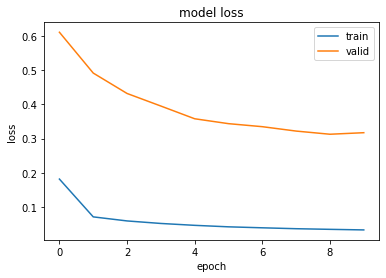

In [10]:
model.plot_train_history()

### Test model
Testing the model on different portions of the test set 

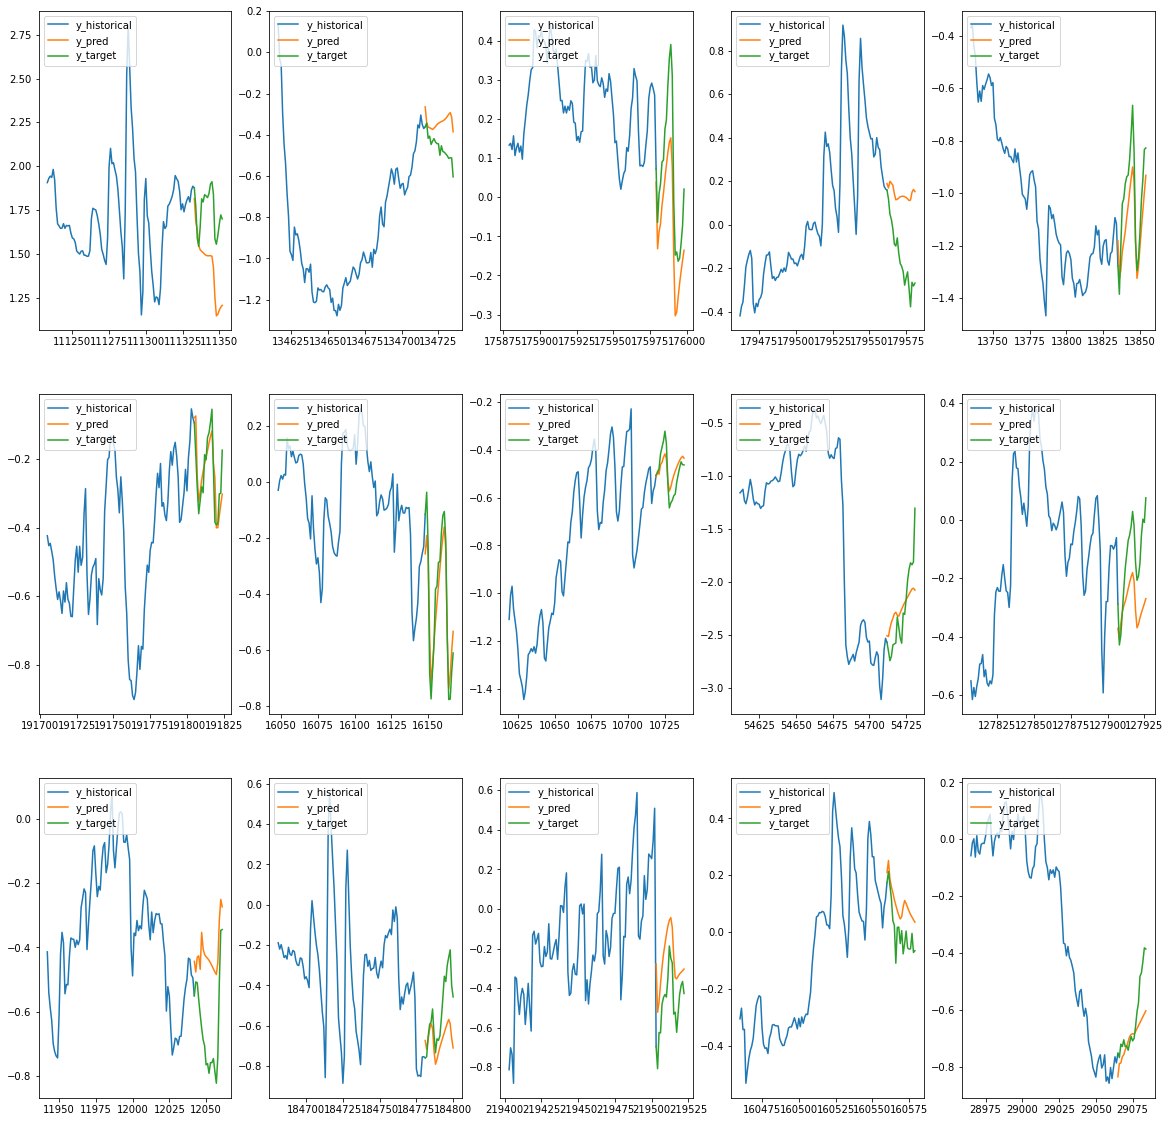

In [11]:
model.forecast_15(x_train, y_train, replace=True, path="./figures/train_set.png")

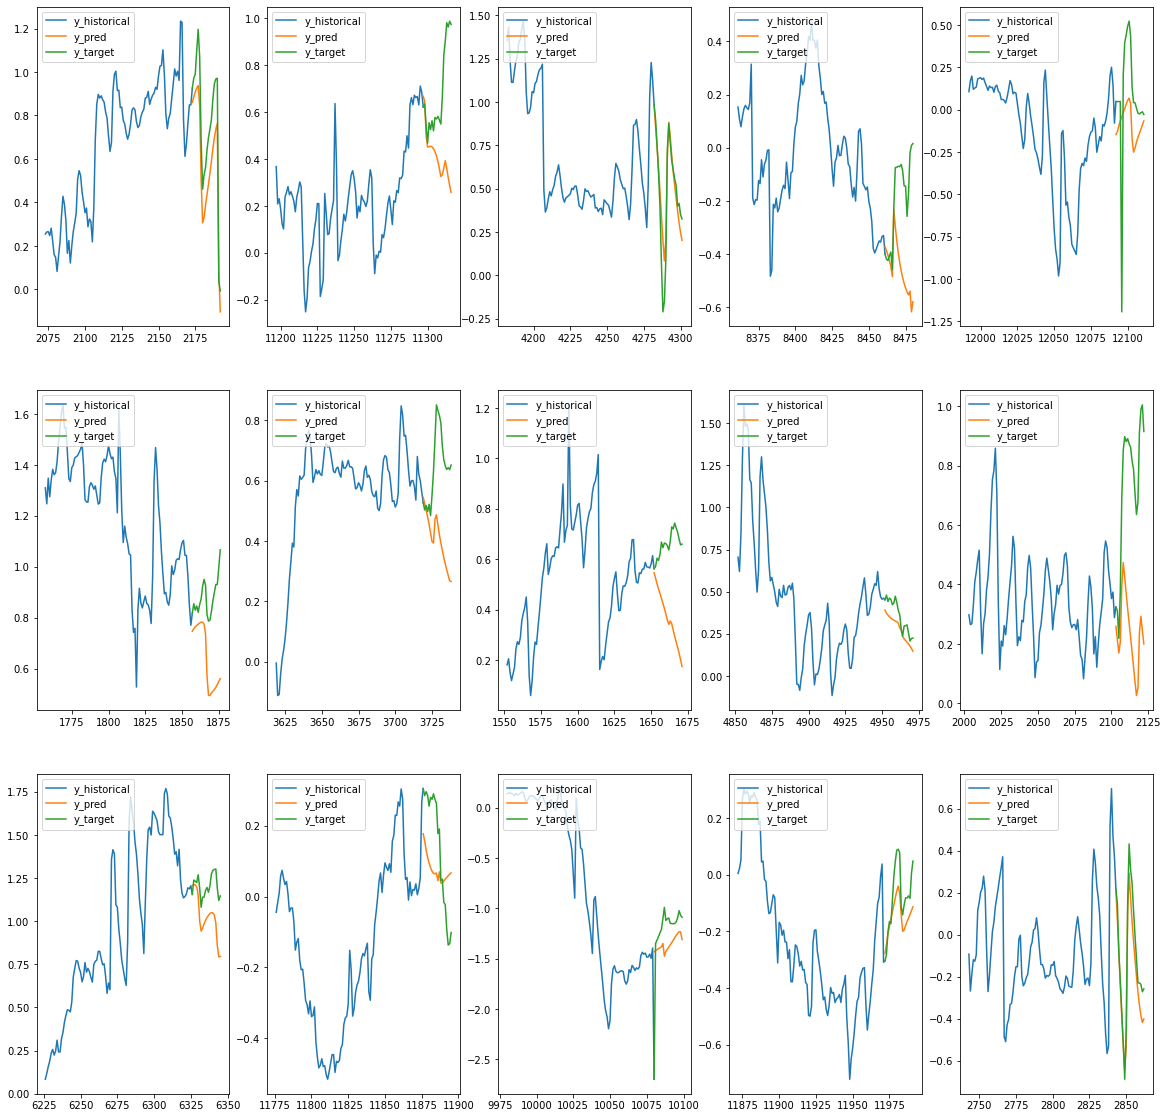

In [21]:
model.forecast_15(x_valid, y_valid,  replace=True, path="./figures/valid_set.png")

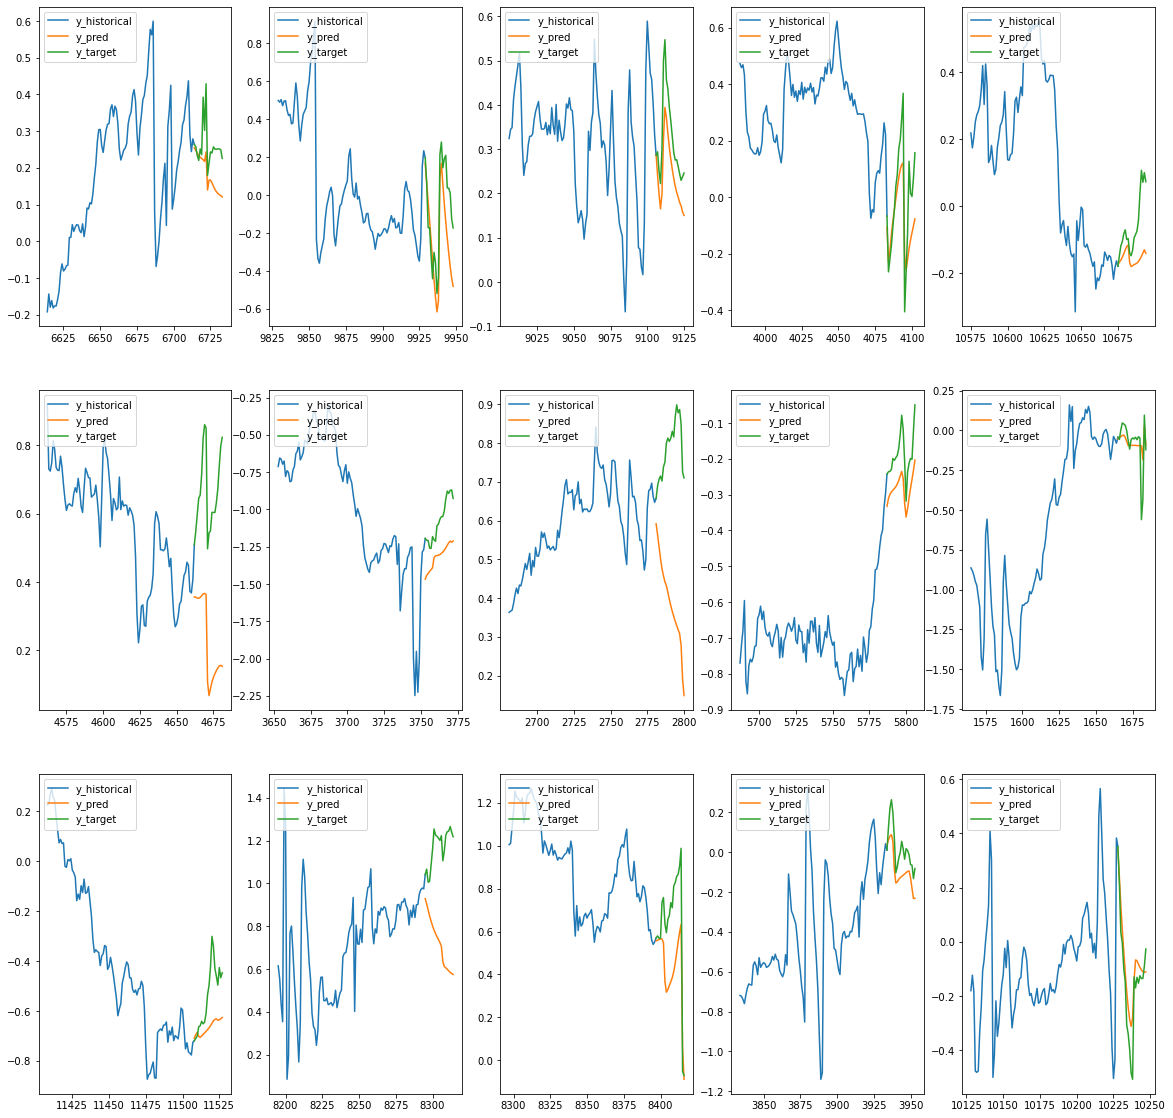

In [22]:
model.forecast_15(x_test, y_test, replace=True, path="./figures/test_set.png")

### Save model

In [19]:
comments = "Removed some features"

In [20]:
metadata = {'features': features, 'k':k, 'comments':comments}
timestamp = datetime.now().isoformat()[:19]
timestamp = timestamp.replace(":", "-")
path = f"models/{timestamp}"
model.save_model(path=f"{path}/model")
with open(f"{path}/metadata.json", 'w') as f:
    json.dump(metadata, f)

INFO:tensorflow:Assets written to: models/2022-04-24T20-07-00/model\assets


INFO:tensorflow:Assets written to: models/2022-04-24T20-07-00/model\assets


#### Load model

In [10]:
model.load_model(path=f"./models/2022-04-22T17-36-02/model", new_k=60)

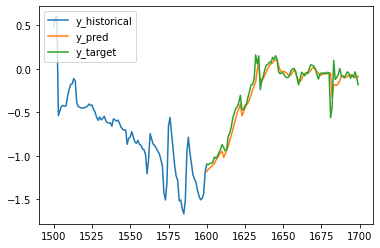

In [24]:
model.forecast_1(x_test, y_test, M=100, n=100, s=1600, replace=False)

### Load and prepare hold out set

In [ ]:
df_t = pd.read_csv("./data/test.csv")
df_train, train_scale = Pipeline.process(data=df_t, altered=True)

In [ ]:
k = 60
features=[
    'hydro', 
    'micro',
    'thermal',
    'wind', 
    'total',
    'sys_reg', 
    'flow', 
    'time_of_day_sin',
    'time_of_day_cos',
    'time_of_week_sin',
    'time_of_week_cos',
    'time_of_year_sin',
    'time_of_year_cos',
    'time_of_hour_sin',
    'time_of_hour_cos',
    'new_hour',
    'sum',
    'structural_imbalance',
    'prev_day_y',
    'prev_week_y',
    # 'previous_20y']
    'previous_y']
no_features = len(features)

In [ ]:
x_test, y_test = Pipeline.format_data(df_t, k=k, features=features)

Test model

In [ ]:
model.forecast_15(x_test, y_test, replace=True, path="./figures/test_set.png")

In [ ]:
model.forecast_1(x_test, y_test, M=100, n=300, s=1600, replace=True)

# Feature importance estimates

In [22]:
import numpy as np


In [207]:
feat = ['sum']

In [208]:
df_t = df_test.copy(deep=True)
df_t[feat] = np.random.random((len(df_t), len(feat)))
x_test, y_test = Pipeline.format_data(df_t, k=k, features=features)


In [14]:
feat = "test"

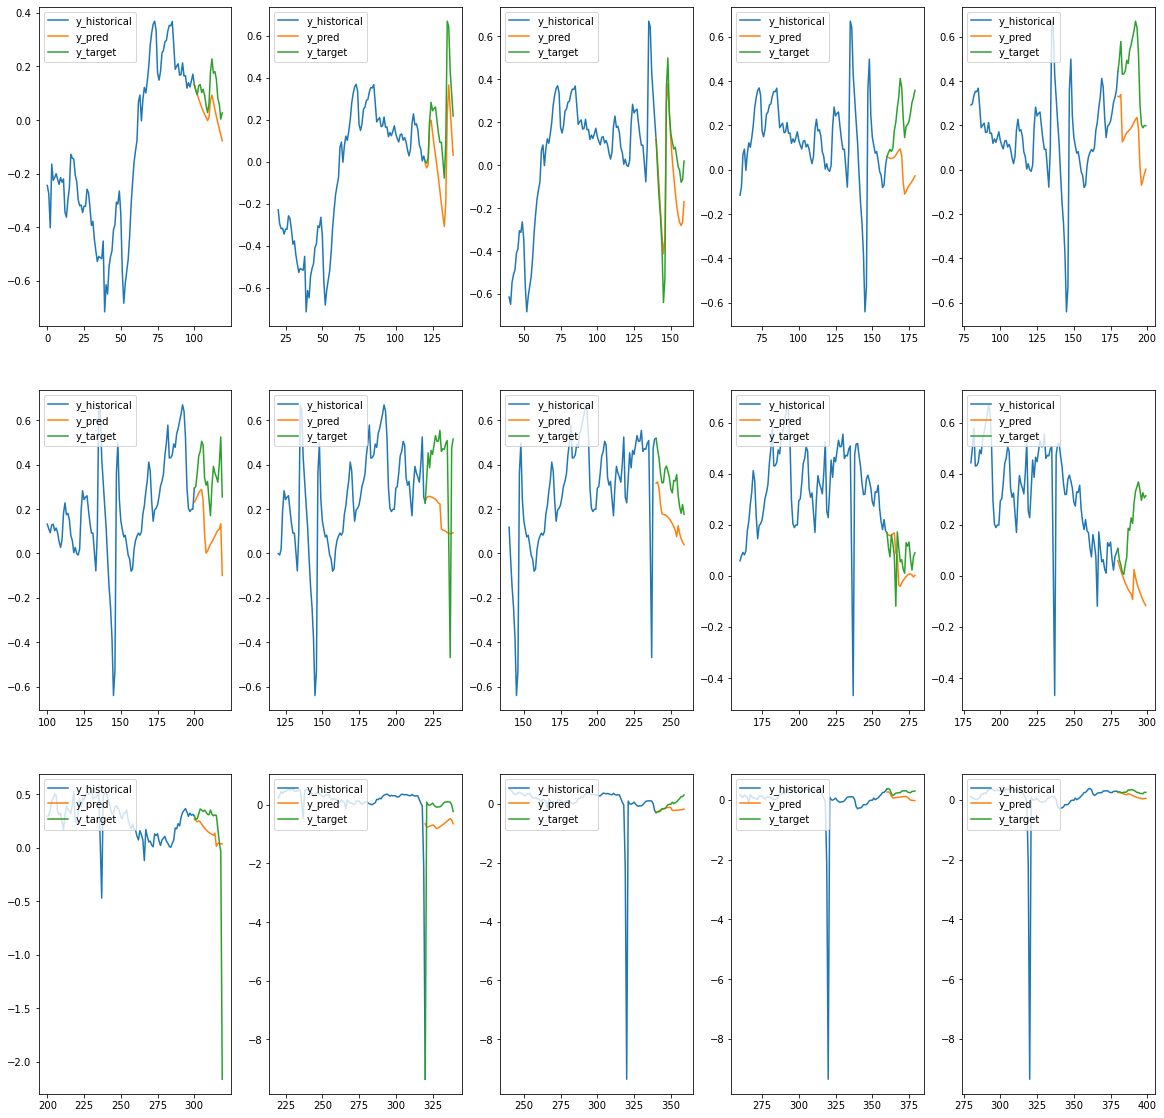

In [15]:
model.forecast_15(x_test, y_test, replace=True, path=f"./figures/{feat}.png", benchmark=True)

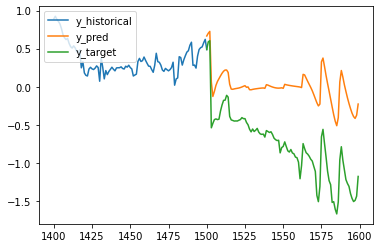

In [18]:
model.forecast_1(x_test, y_test, M=100, n=100, s=1500, replace=True)

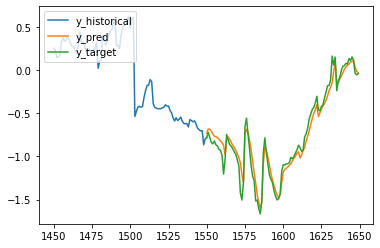

In [17]:
model.forecast_1(x_test, y_test, M=100, n=100, s=1550, replace=False)

In [213]:
pred = model.predict(x_test)
loss = RNN.root_mean_squared_error(y_test, pred)
print(loss)

tf.Tensor(0.6582264589650821, shape=(), dtype=float64)


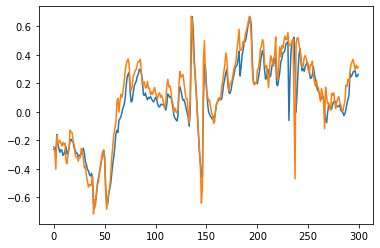

In [214]:
plt.plot(range(300), pred[:300])
plt.plot(range(300), y_test[:300])